# Understanding Influencer Impact: An Unsupervised Study

**Authors**: Shreeyut Neupane (sn740), Zeel Patel (zpp8)  
**Course**: Intro to Data Science (CS439)  
**Project Goal**: Use unsupervised learning to analyze social media influencer content, engagement patterns, and hidden audience groups.

---

## 1. Introduction

- Brief summary of the problem
- Relevance of studying influencer impact
- Objectives of this analysis


In [4]:
# Load all essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sn740/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sn740/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Data Collection

- Explain which platform(s) you pulled data from (YouTube, Twitter, etc.)
- Show a sample of collected CSVs



In [5]:
# Load CSVs from Youtube 
yt_fitness = pd.read_csv('yt_fitness_data.csv')  
yt_skincare = pd.read_csv('yt_skincare_data.csv')      

# Load CSVs from Reddit 
reddit_fitness = pd.read_csv('reddit_fitness.csv')  
reddit_skincare = pd.read_csv('reddit_skincare.csv')     

## 3. Data Cleaning & Preprocessing

- Remove duplicates, fill/drop nulls
- Normalize text
- Extract date/time features if needed


In [6]:
# Cleaning YouTube data
def clean_youtube(df):
    df = df.drop_duplicates()
    df = df.dropna(how='all')
    df = df.fillna('')
    if 'description' in df.columns:
        df['description'] = df['description'].astype(str).str.lower()
        df['description'] = df['description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    if 'publishedAt' in df.columns:
        df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
        df['year'] = df['publishedAt'].dt.year
        df['month'] = df['publishedAt'].dt.month
        df['day'] = df['publishedAt'].dt.day
    return df
    
# Cleaning Reddit data
def clean_reddit(df):
    df = df.drop_duplicates()
    df = df.dropna(how='all')
    df = df.fillna('')
    if 'comment_body' in df.columns:
        df = df[~df['comment_body'].str.strip().isin(['[removed]', '[deleted]'])]
        # Normalize text
        df['comment_body'] = df['comment_body'].astype(str).str.lower()
        df['comment_body'] = df['comment_body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    if 'created_utc' in df.columns:
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
        df['year'] = df['created_utc'].dt.year
        df['month'] = df['created_utc'].dt.month
        df['day'] = df['created_utc'].dt.day
    return df

yt_fitness = clean_youtube(yt_fitness)
yt_skincare = clean_youtube(yt_skincare)
reddit_fitness = clean_reddit(reddit_fitness)
reddit_skincare = clean_reddit(reddit_skincare)
for name, df in [('yt_fitness', yt_fitness), 
                 ('yt_skincare', yt_skincare), 
                 ('reddit_fitness', reddit_fitness), 
                 ('reddit_skincare', reddit_skincare)]:
    
    print(f"\n{'='*40}")
    print(f"Dataset: {name.upper()}")
    print(f"{'-'*40}")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nNull Counts:")
    print(df.isnull().sum())
    print(f"{'='*40}\n")


Dataset: YT_FITNESS
----------------------------------------
Shape: (213, 12)

Columns:
['videoId', 'title', 'description', 'tags', 'likeCount', 'commentCount', 'viewCount', 'publishedAt', 'channelTitle', 'year', 'month', 'day']

Null Counts:
videoId         0
title           0
description     0
tags            0
likeCount       0
commentCount    0
viewCount       0
publishedAt     0
channelTitle    0
year            0
month           0
day             0
dtype: int64


Dataset: YT_SKINCARE
----------------------------------------
Shape: (94, 11)

Columns:
['videoId', 'title', 'description', 'tags', 'publishedAt', 'likeCount', 'commentCount', 'viewCount', 'year', 'month', 'day']

Null Counts:
videoId         0
title           0
description     0
tags            0
publishedAt     0
likeCount       0
commentCount    0
viewCount       0
year            0
month           0
day             0
dtype: int64


Dataset: REDDIT_FITNESS
----------------------------------------
Shape: (171, 11)

Co

## 4. Sentiment Analysis (TextBlob)

- Add sentiment polarity column

In [7]:
# Reddit Sentiment Analysis
reddit_fitness['sentiment_score'] = reddit_fitness['comment_body'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)
reddit_skincare['sentiment_score'] = reddit_skincare['comment_body'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

In [8]:
# YouTube Sentiment Analysis
yt_fitness['sentiment_score'] = yt_fitness['description'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)
yt_skincare['sentiment_score'] = yt_skincare['description'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

## 5. Correlation Analysis

- Engagement vs sentiment


In [9]:
# Reddit Correlation
print("\nReddit Fitness Correlation")
print(reddit_fitness[['sentiment_score', 'score', 'post_upvotes', 'post_comments']].corr())

print("Reddit Skincare Correlation")
print(reddit_skincare[['sentiment_score', 'score', 'post_upvotes', 'post_comments']].corr())


Reddit Fitness Correlation
                 sentiment_score     score  post_upvotes  post_comments
sentiment_score         1.000000 -0.232285     -0.138186       0.129179
score                  -0.232285  1.000000      0.523854      -0.251415
post_upvotes           -0.138186  0.523854      1.000000      -0.371532
post_comments           0.129179 -0.251415     -0.371532       1.000000
Reddit Skincare Correlation
                 sentiment_score     score  post_upvotes  post_comments
sentiment_score         1.000000 -0.022659     -0.059383      -0.140683
score                  -0.022659  1.000000      0.221442       0.202750
post_upvotes           -0.059383  0.221442      1.000000       0.717238
post_comments          -0.140683  0.202750      0.717238       1.000000


In [ ]:
# Reddit Heatmaps
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(reddit_fitness[['sentiment_score', 'score', 'post_upvotes', 'post_comments']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Reddit Fitness Correlation')
plt.subplot(1, 2, 2)
sns.heatmap(reddit_skincare[['sentiment_score', 'score', 'post_upvotes', 'post_comments']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Reddit Skincare Correlation')
plt.tight_layout()
plt.show()

In [11]:
# YouTube Correlation

# numeric columns
yt_fitness[['likeCount', 'commentCount', 'viewCount']] = yt_fitness[['likeCount', 'commentCount', 'viewCount']].apply(pd.to_numeric, errors='coerce')
yt_skincare[['likeCount', 'commentCount', 'viewCount']] = yt_skincare[['likeCount', 'commentCount', 'viewCount']].apply(pd.to_numeric, errors='coerce')

print("\nYouTube Fitness Correlation")
print(yt_fitness[['sentiment_score', 'likeCount', 'commentCount', 'viewCount']].corr())
print("\nYouTube Skincare Correlation")
print(yt_skincare[['sentiment_score', 'likeCount', 'commentCount', 'viewCount']].corr())


YouTube Fitness Correlation
                 sentiment_score  likeCount  commentCount  viewCount
sentiment_score         1.000000   0.008636      0.033067   0.038383
likeCount               0.008636   1.000000      0.859740   0.882143
commentCount            0.033067   0.859740      1.000000   0.935244
viewCount               0.038383   0.882143      0.935244   1.000000

YouTube Skincare Correlation
                 sentiment_score  likeCount  commentCount  viewCount
sentiment_score         1.000000   0.114089      0.189011   0.181824
likeCount               0.114089   1.000000      0.491527   0.964094
commentCount            0.189011   0.491527      1.000000   0.535444
viewCount               0.181824   0.964094      0.535444   1.000000


In [ ]:
# YouTube Heatmaps
# numeric columns
yt_fitness[['likeCount', 'commentCount', 'viewCount']] = yt_fitness[['likeCount', 'commentCount', 'viewCount']].apply(pd.to_numeric, errors='coerce')
yt_skincare[['likeCount', 'commentCount', 'viewCount']] = yt_skincare[['likeCount', 'commentCount', 'viewCount']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(yt_fitness[['sentiment_score', 'likeCount', 'commentCount', 'viewCount']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('YouTube Fitness Correlation')
plt.subplot(1, 2, 2)
sns.heatmap(yt_skincare[['sentiment_score', 'likeCount', 'commentCount', 'viewCount']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('YouTube Skincare Correlation')
plt.tight_layout()
plt.show()

**The results show that sentiment doesn’t strongly influence engagement in most cases, except for YouTube skincare content. On Reddit, whether a comment is positive or negative doesn’t seem to affect how many upvotes or replies it gets, especially in the fitness and skincare communities. The same goes for YouTube fitness videos people seem to watch, like, and comment regardless of how positive or negative the video description sounds. But for YouTube skincare videos, there’s a noticeable trend... the more positive the description, the more engagement the video tends to get. This suggests that in the beauty space, tone does matter, and viewers may respond more to content that feels positive or inviting.**

## 6. Frequency Analysis

- Top words used
- Word frequency plots


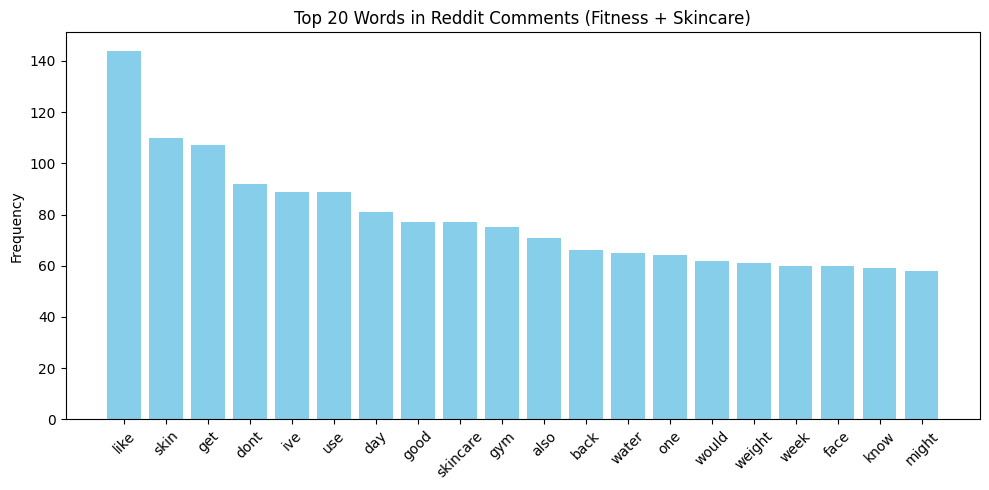

In [13]:
from nltk.corpus import stopwords
from collections import Counter

stop_words = set(stopwords.words('english'))

# Combine all Reddit comment
reddit_text = ' '.join(reddit_fitness['comment_body'].tolist() + reddit_skincare['comment_body'].tolist())

# Tokenize and clean
reddit_tokens = reddit_text.lower().split()
reddit_filtered = [word for word in reddit_tokens if word not in stop_words and len(word) > 2]

# Count frequency
reddit_freq = Counter(reddit_filtered).most_common(20)

# Plot
words_r, counts_r = zip(*reddit_freq)
plt.figure(figsize=(10, 5))
plt.bar(words_r, counts_r, color='skyblue')
plt.title("Top 20 Words in Reddit Comments (Fitness + Skincare)")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

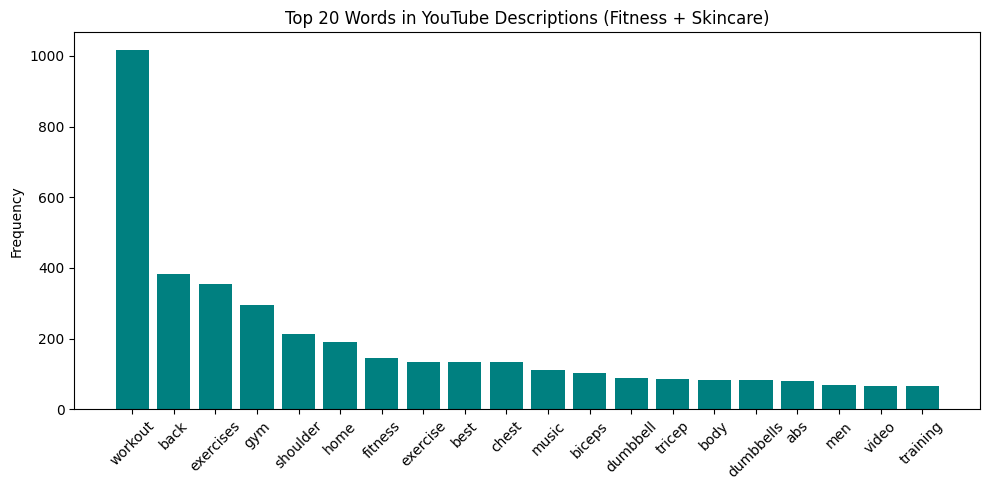

In [14]:
yt_text = ' '.join(yt_fitness['description'].tolist() + yt_skincare['description'].tolist())

# Tokenize and clean
yt_tokens = yt_text.lower().split()
yt_filtered = [word for word in yt_tokens if word not in stop_words and len(word) > 2]

# Count frequency
yt_freq = Counter(yt_filtered).most_common(20)

# Plot
words_y, counts_y = zip(*yt_freq)
plt.figure(figsize=(10, 5))
plt.bar(words_y, counts_y, color='teal')
plt.title("Top 20 Words in YouTube Descriptions (Fitness + Skincare)")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## 7. Clustering with K-Means

- Vectorize text using TF-IDF
- Fit KMeans
- Visualize clusters


# K-Means for Reddit

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

reddit_text = reddit_fitness['comment_body'].tolist() + reddit_skincare['comment_body'].tolist()

# TF-IDF 
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_reddit = vectorizer.fit_transform(reddit_text)

# KMeans clustering
k_reddit = 4  #Chosen with Elbow Method from below
kmeans_reddit = KMeans(n_clusters=k_reddit, random_state=100)
kmeans_reddit.fit(X_reddit)

# Top terms in each cluster
terms = vectorizer.get_feature_names_out()
print("Top terms per Reddit cluster:")
for i in range(k_reddit):
    center = kmeans_reddit.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_indices]
    print(f"Cluster {i+1}: {', '.join(top_terms)}")

Top terms per Reddit cluster:
Cluster 1: marshalls, cream, got, use, water, local, skin, selling, yes, multiple
Cluster 2: im, like, just, gym, day, ive, week, weight, skin, doing
Cluster 3: use, face, water, sunscreen, wash, dont, skin, wipes, bad, like
Cluster 4: skincare, concerns, moderators, contact, action, automatically, performed, bot, questions, post


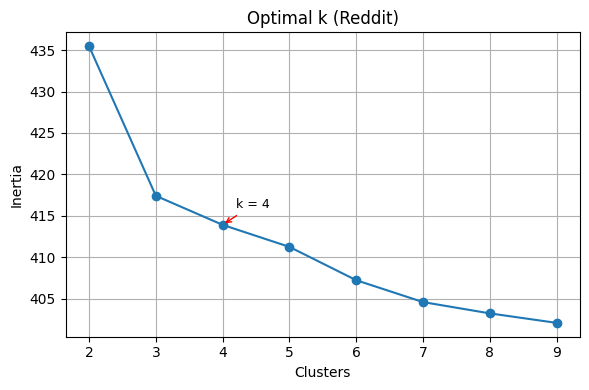

In [16]:
inertias = []
k_range = range(2, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=100)
    model.fit(X_reddit)
    inertias.append(model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Optimal k (Reddit)")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.annotate('k = 4',
             xy=(4, inertias[2]),           
             xytext=(4.2, inertias[2] + 2), 
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=9)
plt.tight_layout()
plt.show()

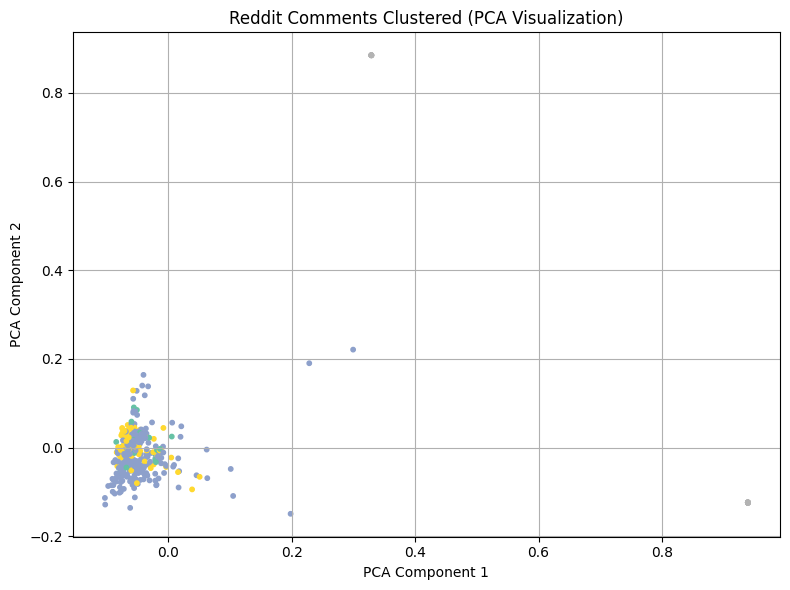

In [17]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=2, random_state=100)
X_reddit_2D = pca.fit_transform(X_reddit.toarray())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_reddit_2D[:, 0], X_reddit_2D[:, 1], c=kmeans_reddit.labels_, cmap='Set2', s=10)
plt.title("Reddit Comments Clustered (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# K-Means for Youtube

In [18]:
yt_text = yt_fitness['description'].tolist() + yt_skincare['description'].tolist()

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_yt = vectorizer.fit_transform(yt_text)

# KMeans clustering
k_yt = 3  #Chosen with Elbow Method from below
kmeans_yt = KMeans(n_clusters=k_yt, random_state=100)
kmeans_yt.fit(X_yt)

# Top terms in each cluster
terms = vectorizer.get_feature_names_out()
print("Top terms per YouTube cluster:")
for i in range(k_yt):
    center = kmeans_yt.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_indices]
    print(f"Cluster {i+1}: {', '.join(top_terms)}")

Top terms per YouTube cluster:
Cluster 1: workout, fitness, dumbbell, skincare, makeup, training, instagram, gym, reps, video
Cluster 2: wants, minimal, girl, gym, just, workout, beginner, arm, beginners, perfect
Cluster 3: workout, gym, exercises, fitness, home, exercise, chest, shoulder, best, abs


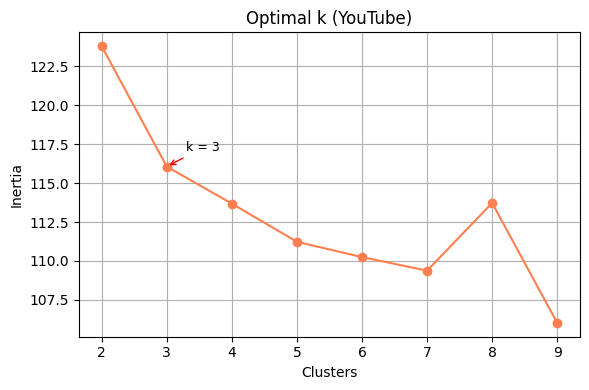

In [19]:
inertias = []
k_range = range(2, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=100)
    model.fit(X_yt)
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o', color='coral')
plt.title("Optimal k (YouTube)")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.annotate('k = 3',
             xy=(3, inertias[1]),
             xytext=(3.3, inertias[1] + 1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=9)
plt.tight_layout()
plt.show()

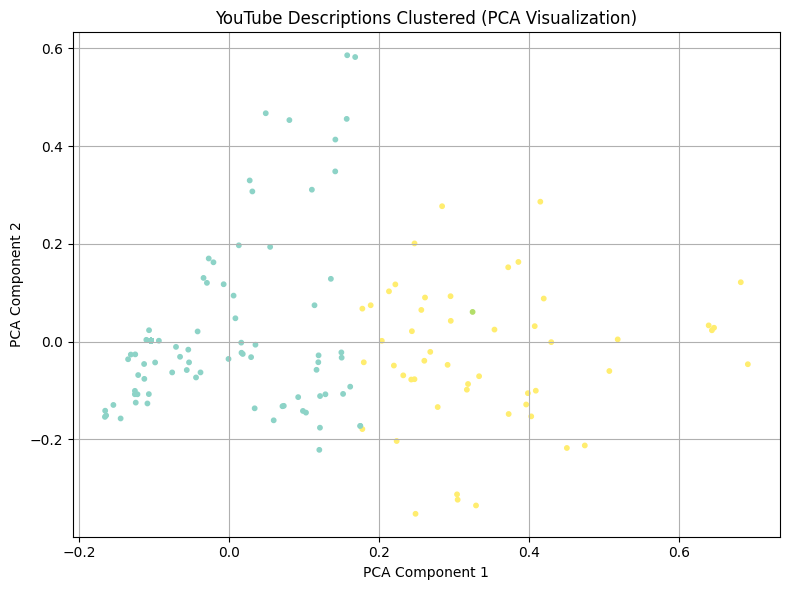

In [20]:
# Reduce dimensions to 2D
pca = PCA(n_components=2, random_state=100)
X_yt_2D = pca.fit_transform(X_yt.toarray())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_yt_2D[:, 0], X_yt_2D[:, 1], c=kmeans_yt.labels_, cmap='Set3', s=10)
plt.title("YouTube Descriptions Clustered (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

**To better understand how influencer content is grouped based on the words used, we used K-Means clustering with TF-IDF and visualized the results using PCA. In the Reddit graph, we noticed that most of the comments are very close together, meaning people are using similar kinds of language across posts. There are a few small clusters that stand out, which could represent unique types of comments—like advice, reactions, or strong opinions.**

**The YouTube graph looks more spread out, showing that creators use a wider variety of language in their video descriptions. Some clusters are clearly apart from others, which might represent different types of videos like tutorials, personal stories, or promotional content. These clusters help us see what kinds of content are naturally grouped together based on wording, and we can later check which clusters get more views, likes, or comments.**

## 8. Topic Modeling (NMF)

- Extract themes using NMF or LDA


## Reddit  NMF

In [21]:
from sklearn.decomposition import NMF

# Combine Reddit comments
reddit_text = reddit_fitness['comment_body'].tolist() + reddit_skincare['comment_body'].tolist()

# TF-IDF Vectorization
vectorizer_r = TfidfVectorizer(stop_words='english', max_features=1000)
X_reddit = vectorizer_r.fit_transform(reddit_text)

# Apply NMF
n_topics = 5
nmf_reddit = NMF(n_components=n_topics, random_state=100)
W_reddit = nmf_reddit.fit_transform(X_reddit)
H_reddit = nmf_reddit.components_
terms_r = vectorizer_r.get_feature_names_out()

# Display top words per topic
print("Reddit Topics:\n")
for idx, topic in enumerate(H_reddit):
    top_words = [terms_r[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

Reddit Topics:

Topic 1: skincare, guides, faith, welcome, sca, communityhttpswwwredditcomrskincareaddictionwikiabout, routinehttpswwwredditcomrskincareaddictionwikisca_routine, wikihttpswwwredditcomrskincareaddictionwikiindex, subredditmessagecomposetorskincareaddiction, assume
Topic 2: im, gym, week, ive, weight, just, day, doing, like, days
Topic 3: form, help, guidelineshttpswwwredditcomrfitnesswikiposting_guidelineswiki_how_to_post_a_form_check, checks, subredditmessagecomposetorfitness, replies, comment, check, follow, results
Topic 4: use, skin, face, like, acne, just, sunscreen, products, try, wash
Topic 5: water, difference, drinking, face, day, distilled, skin, hard, whats, problem


In [22]:
# Assign dominant topic to each Reddit comment
reddit_combined = pd.concat([reddit_fitness, reddit_skincare], ignore_index=True)
reddit_combined['topic'] = W_reddit.argmax(axis=1)

# Calculate average engagement per topic
reddit_topic_stats = reddit_combined.groupby('topic')[['score', 'post_upvotes', 'post_comments']].mean()

print("Average Reddit Engagement by Topic:")
print(reddit_topic_stats)

Average Reddit Engagement by Topic:
           score  post_upvotes  post_comments
topic                                        
0      54.090909    134.878788      64.272727
1      16.243386     49.291005     123.931217
2       3.000000     40.642857     117.500000
3      56.136842    157.378947      93.289474
4      14.281250    132.593750      56.312500


## YouTube NMF

In [23]:
# Combine YouTube descriptions
yt_text = yt_fitness['description'].tolist() + yt_skincare['description'].tolist()

# TF-IDF Vectorization
vectorizer_y = TfidfVectorizer(stop_words='english', max_features=1000)
X_yt = vectorizer_y.fit_transform(yt_text)

# apply NMF
nmf_yt = NMF(n_components=n_topics, random_state=100)
W_yt = nmf_yt.fit_transform(X_yt)
H_yt = nmf_yt.components_
terms_y = vectorizer_y.get_feature_names_out()

# Display top words per topic
print("YouTube Topics:\n")
for idx, topic in enumerate(H_yt):
    top_words = [terms_y[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

YouTube Topics:

Topic 1: workout, exercises, gym, home, chest, abs, shoulder, best, exercise, biceps
Topic 2: training, fat, video, program, body, exercise, cardio, use, good, strength
Topic 3: dumbbell, reps, 4x10, press, shoulder, chest, bodybuilding, curl, bench, 3x12
Topic 4: makeup, skincare, influencer, beauty, pr, vogue, lip, review, routine, early
Topic 5: fitness, gym, calisthenics, workout, fitnessfaqscom, bodybuilding, shorts, master, workouts, shop


In [25]:
# dominant topic to each YouTube description
yt_combined = pd.concat([yt_fitness, yt_skincare], ignore_index=True)
yt_combined['topic'] = W_yt.argmax(axis=1)

# numeric types
for col in ['likeCount'
            , 'commentCount', 'viewCount']:
    yt_combined[col] = pd.to_numeric(yt_combined[col], errors='coerce')

# Calculate average engagement per topic
yt_topic_stats = yt_combined.groupby('topic')[['likeCount', 'commentCount', 'viewCount']].mean()

print("Average YouTube Engagement by Topic:")
print(yt_topic_stats)

Average YouTube Engagement by Topic:
           likeCount  commentCount     viewCount
topic                                           
0      102475.561321    596.471698  2.901503e+06
1      255788.656250   2623.218750  9.277712e+06
2       76298.736842    307.421053  2.050704e+06
3      141296.294118   1566.000000  3.751358e+06
4      220035.000000   1448.481481  5.353589e+06


## 9. Visualizations

- Show all relevant plots: histograms, scatter plots, cluster visuals


## Reddit Graphs

In [ ]:
# Bar Chart: Average Engagement per Topic
plt.figure(figsize=(12, 5))
reddit_topic_stats.plot(kind='bar', figsize=(12, 5), colormap='Set2')
plt.title("Reddit: Average Engagement by Topic")
plt.ylabel("Average Count")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Scatter Plot: Sentiment vs Upvotes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=reddit_combined, x='sentiment_score', y='score', hue='topic', palette='Set2', alpha=0.7)
plt.title("Reddit: Sentiment Score vs Comment Upvotes")
plt.xlabel("Sentiment Score")
plt.ylabel("Comment Score (Upvotes)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Youtube Graphs

In [ ]:
# Bar Chart: Average Engagement per Topic
plt.figure(figsize=(12, 5))
yt_topic_stats.plot(kind='bar', figsize=(12, 5), colormap='Set3')
plt.title("YouTube: Average Engagement by Topic (Log Scale)")
plt.ylabel("Average Count (log scale)")
plt.yscale('log')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Scatter Plot: Sentiment vs View Count
plt.figure(figsize=(8, 6))
sns.scatterplot(data=yt_combined, x='sentiment_score', y='viewCount', hue='topic', palette='Set3', alpha=0.7)
plt.title("YouTube: Sentiment Score vs View Count")
plt.xlabel("Sentiment Score")
plt.ylabel("View Count")
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Conclusion & Insights

- Summary of findings
- Limitations
- Future improvements


This project explored how people engage with influencer content on Reddit and YouTube by analyzing text (comments and descriptions) through sentiment analysis, clustering, and topic modeling. 

We found that:
- On YouTube, especially for skincare content, **positive sentiment** in descriptions was moderately correlated with higher views and likes.
- On Reddit, sentiment had **little effect** on engagement, suggesting other factors like relevance or timing matter more.
- **Clustering** helped group content into natural types.
- **Topic modeling** revealed themes (e.g., routines, reactions, tutorials) that attracted more engagement.

These insights show that **tone and topic** influence audience behavior—especially on more visual, lifestyle-driven platforms like YouTube.

---

#### Limitations
- TextBlob sentiment is basic—it may miss sarcasm, slang, or emotional nuance.
- Engagement metrics (likes, upvotes) are influenced by many factors outside text, like timing or visibility.
- Reddit and YouTube are fundamentally different platforms, so comparisons must be made carefully.
- Topic modeling on short text can be noisy or vague without more context.

---

#### Future Improvements
- Use more advanced sentiment tools (e.g., VADER, BERT-based models).
- Analyze other fields like Reddit post titles and YouTube tags.
- Break down results by **influencer type** (fitness, beauty, tech).
- Include **time-based trends** to explore how engagement shifts over time.
- Create an **interactive dashboard** for exploring sentiment and topic insights more visually.